# py_f2recom overview
Moritz Zeising, moritz.zeising@awi.de

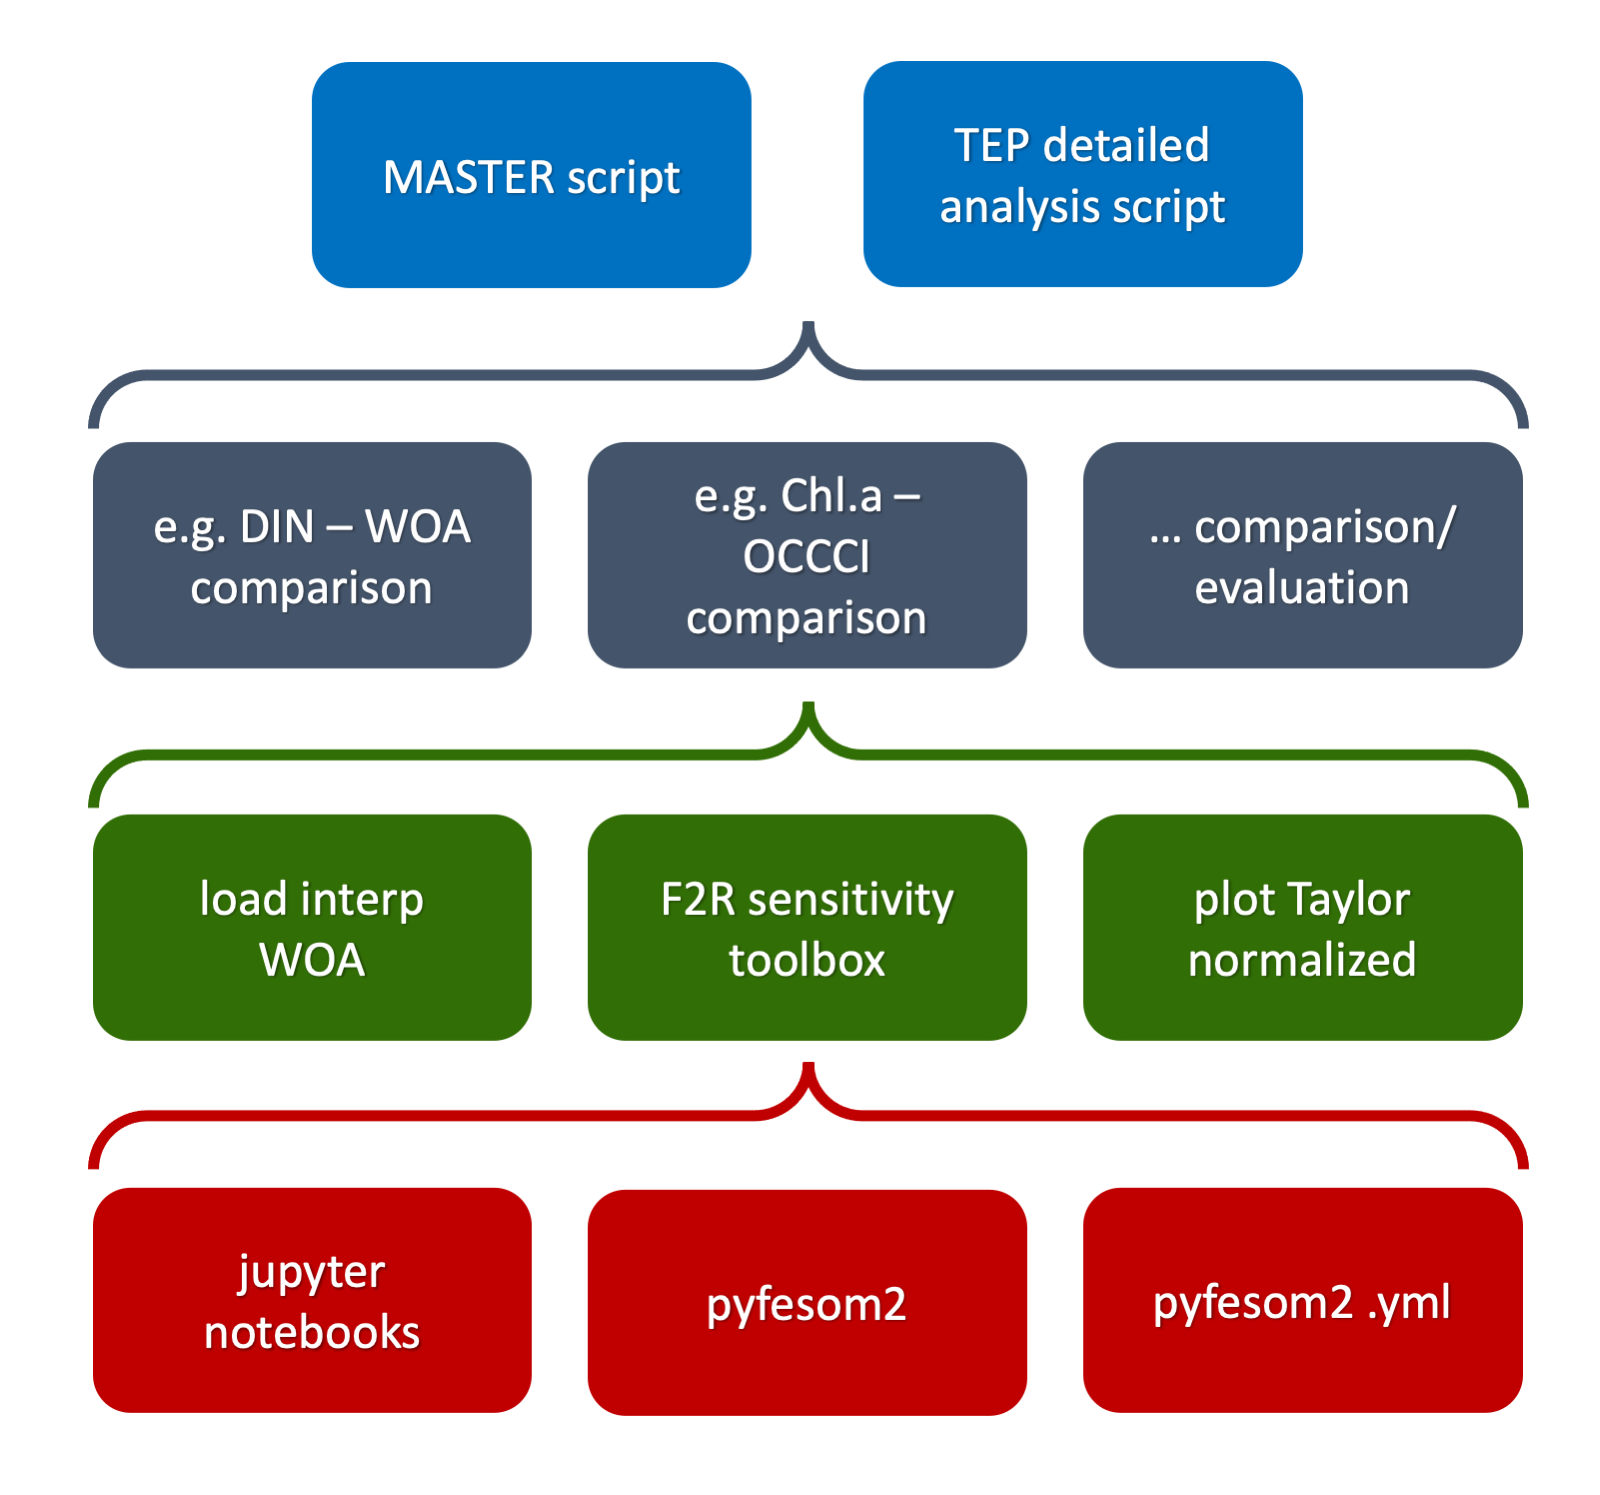

In [1]:
import warnings
warnings.simplefilter("ignore")

from IPython import display
display.Image("./Overview_py_f2recom.png", width = 700)

# Load modules, prepare analysis

In [2]:
# -------------------------------------------------------------------------------
# necessary modules 
import pyfesom2 as pf
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


In [3]:
# -------------------------------------------------------------------------------
# run specification    
runid      =  'fesom'
layerwise    = False
resultpath = '/work/ollie/mozeisin/results/f2r1.2/tep2'
meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

# period of analysis 
first_year = 1948
last_year  = 1970
    
years = np.arange(first_year,last_year+1,1)
years_last10 = np.arange(last_year-10,last_year+1,1)

In [4]:
# -------------------------------------------------------------------------------
# specification of analysis 
depth = 0
layerwise = False
mapproj = 'rob'
#Map projection. Options are Mercator (merc), Plate Carree (pc),
#North Polar Stereo (np), South Polar Stereo (sp),  Robinson (rob)
#Robinson projection is quite time consuming.

# -------------------------------------------------------------------------------
# export of analysis 
savepath = '/home/ollie/mozeisin/evaluation/mo_files/'
savefig = False
htmlname = 'test.html'
htmlpath = '/home/ollie/mozeisin/evaluation/mo_files/html/'

In [5]:
# -------------------------------------------------------------------------------
# mesh initialization 
mesh = pf.load_mesh(meshpath)

# 1) Example: Use of pyfesom2 tools for simple plotting

## Map of total Diatom NPP 

In [6]:
NCfesom = resultpath + '/NPPd.fesom.1948.nc'
!ncdump -h $NCfesom

netcdf NPPd.fesom.1948 {
dimensions:
	nod2 = 126858 ;
	time = UNLIMITED ; // (12 currently)
variables:
	double time(time) ;
		time:long_name = "time" ;
		time:units = "seconds since 1948-01-01 0:0:0" ;
	float NPPd(time, nod2) ;
		NPPd:description = "Mean NPP diatoms" ;
		NPPd:units = "mmolC/(m2*d)" ;
}


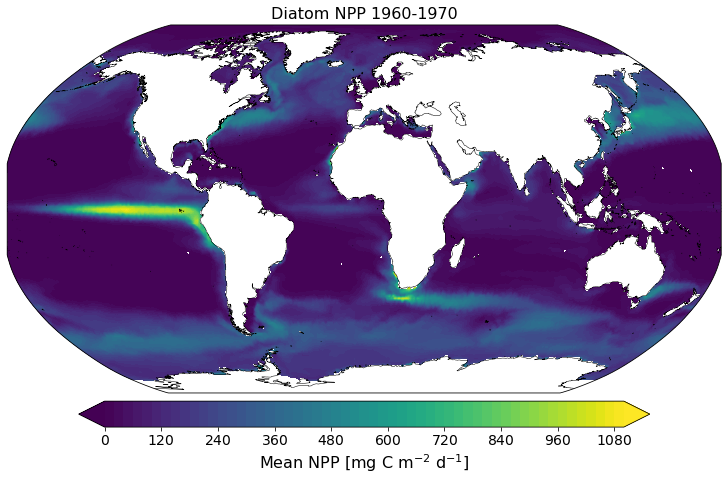

In [7]:
label='Diatom NPP {0}-{1}'.format(last_year-10,last_year)
units = 'Mean NPP [mg C m$^{-2}$ d$^{-1}$]'

# get data
NPPd = pf.get_data(resultpath, "NPPd", 
                   years_last10,
                   mesh, runid=runid, how="mean", compute=True, silent=True)

# 12.01* data --> mmolC/m2/d to mg C/m2/d
NPPd = NPPd * 12.01

# -------------------------------------------------------------------------------
# plotting
fig = pf.plot(mesh, NPPd, mapproj = mapproj, units=units, titles=label, 
              levels = (0,1100,56),
              cmap='viridis')

# 2) Example: plotting chlorophyll

Model depth: 0.0

***
FESOM data was NOT CONVERTED, assuming [mg ChlA/m3]
***


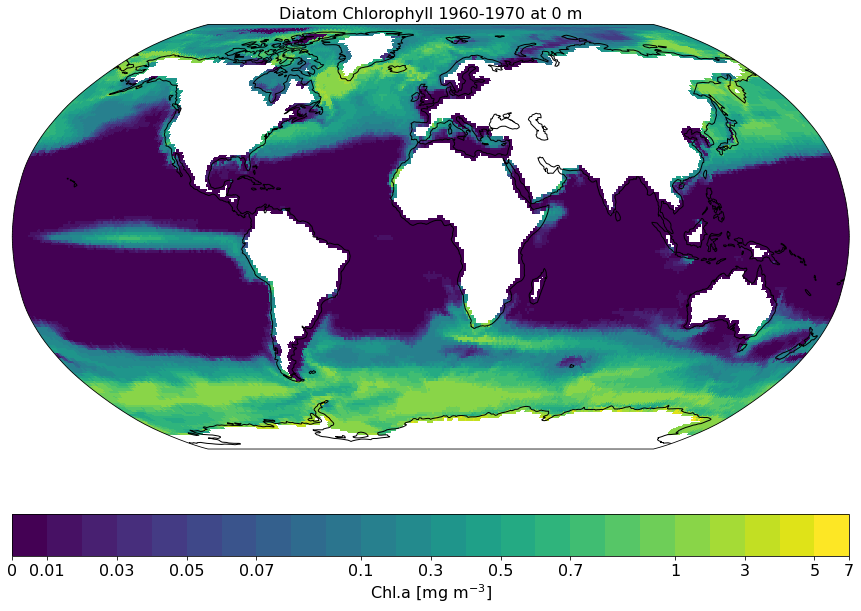

In [8]:
from plot_Chlorophyll_FESOM_python3 import plot_Chl

label='Diatom Chlorophyll {0}-{1} at {2} m'.format(last_year-10,last_year,depth)
units = 'Chl.a [mg m$^{-3}$]' # is that really true?

# -------------------------------------------------------------------------------
fig = plot_Chl(resultpath,'DiaChl',
         years_last10,
         mesh,runid,depth,mapproj,label,units)




# 3) Example: comparison scripts

## DIN comparison with World Ocean Atlas

Processing /work/ollie/mozeisin/results/f2r1.2/tep2
***
Loading WOA file: /work/ollie/projects/MarESys/evaluation/woa13_all_n00_01.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***

Plotting DIN as mean over depth
FESOM min = 0.004865479189902544, max = 34.48279571533203
WOA min = 0.0005629408827170412, max = 34.985260415584484
Min of difference WOA-FESOM: -9.727964507772567


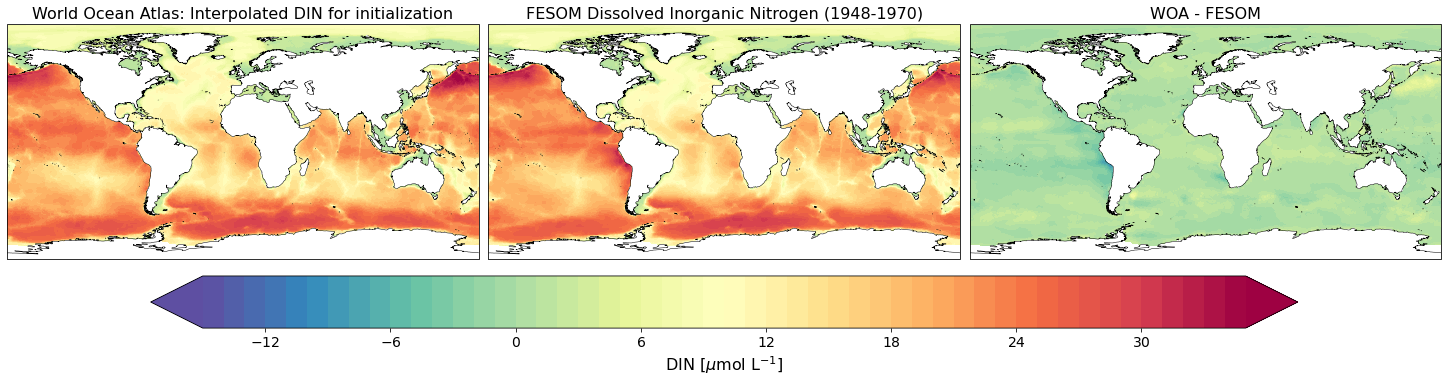


Original Taylor stats:
SDEV pred: 9.38617, ref: 9.27727
CRMS pred: 1.08249, ref: 0.00000
CORRCOEF: 0.99334

Normalized Taylor stats:
SDEV pred: 1.01174, ref: 1.00000
CRMS pred: 0.11668, ref: 0.00000
CORRCOEF: 0.99334
Adjust axis max to 1.5


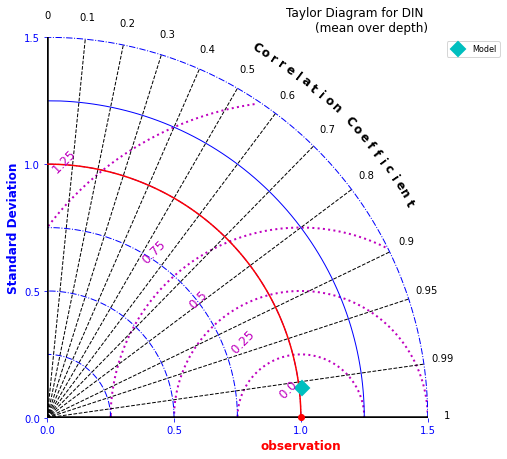

In [9]:
from DIN_WOA_Comparison_python3 import DINcomp

# WOA     
ncpath                = '/work/ollie/projects/MarESys/evaluation/woa13_all_n00_01.nc'

# now test:
test = DINcomp(runid,resultpath,savepath,meshpath,ncpath,first_year,last_year,
               mapproj = 'pc')

## Comparison of Chl surface data with OCCCI

Processing /work/ollie/mozeisin/results/f2r1.2/tep2
***
Using upper 1 layers to depth -5.0 m for surface FESOM data!
***
***
FESOM data in not converted...
***

Chl.a
OCCCI min = 0.0082, max = 53.4243
FESOM min = 0.0000, max = 5.6243 (Mean over 0 to -5.0 m)

log10(Chl.a)
OCCCI min = -2.0880, max = 1.7277
FESOM min = -4.6962, max = 0.7501 (Mean over 0 to -5.0 m)


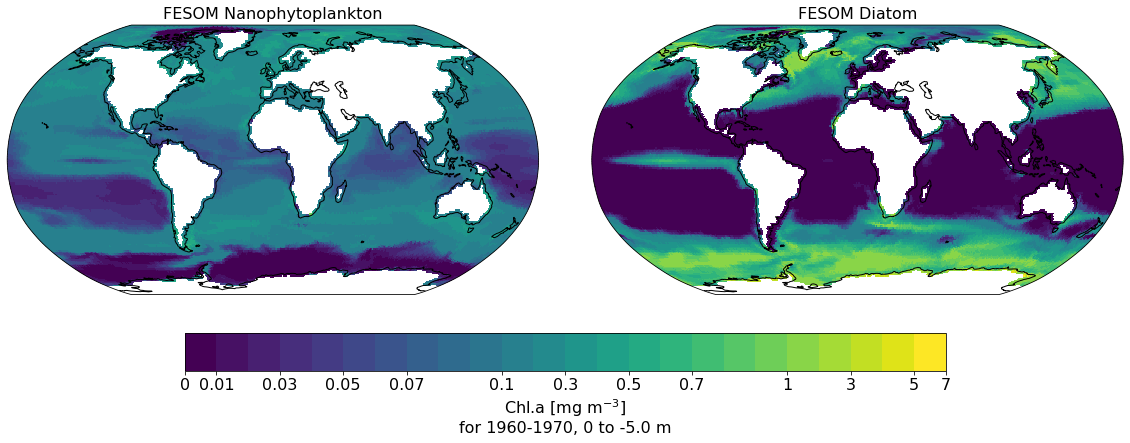

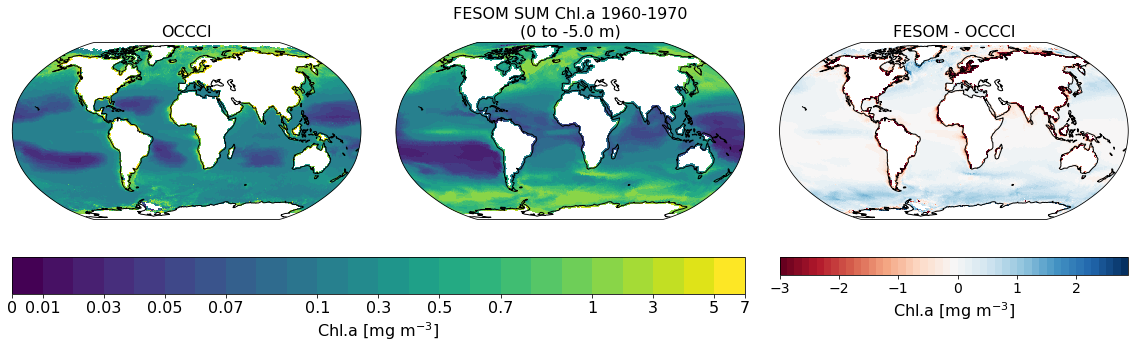


Statistics for log10 surface Chlorophyll

Original Taylor stats:
SDEV pred: 0.49726, ref: 0.44571
CRMS pred: 0.44687, ref: 0.00000
CORRCOEF: 0.55549

Normalized Taylor stats:
SDEV pred: 1.11567, ref: 1.00000
CRMS pred: 1.00261, ref: 0.00000
CORRCOEF: 0.55549
Adjust axis max to 1.5


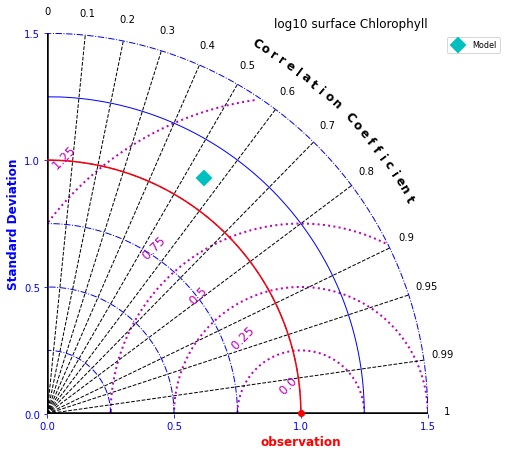

In [10]:
from Chlsurf_OCCCI_Comparison_python3 import Chlsurf_OCCCI_comp

# OCCCI
matfileChlsurf           = '/work/ollie/projects/MarESys/evaluation/climatology_annual_chl_1deg_OCCCI_2012_2015.mat'

# analyze only last 10 years
test = Chlsurf_OCCCI_comp(runid,resultpath,savepath,meshpath,matfileChlsurf,
                          last_year-10,last_year,
                          mapproj=mapproj,savefig=savefig)


# 4) Example: time series scripts
## NPP and export production

Processing /work/ollie/mozeisin/results/f2r1.2/tep2


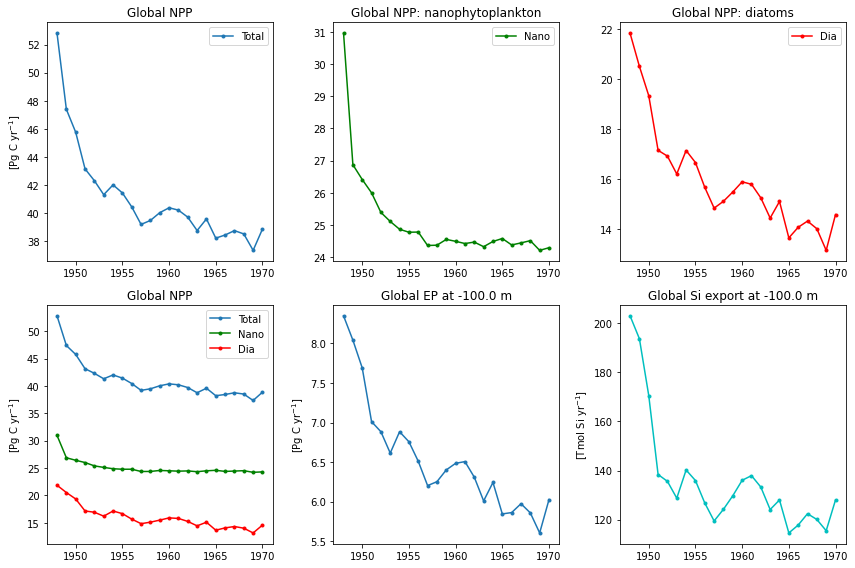

In [11]:
# time-series of NPP and export production

from NPP_TotalGlobal_python3 import NPP_TotalGlobal

test = NPP_TotalGlobal(runid,resultpath,savepath,meshpath,first_year,last_year,savefig=savefig)

### export production --> detritus sinking out of 100 m depth       


# 5) Example: monthly output processing
## Load sea ice data and calculate seasonal cycle

In [12]:
from F2R_sensitivity_toolbox import var_monthly

aIce_monthly = var_monthly(resultpath, 'a_ice', years_last10, mesh, only2D=True)

aIce_monthly.seasonalcycle()

Processing 2D for variable "a_ice"
loading 1960
loading 1961
loading 1962
loading 1963
loading 1964
loading 1965
loading 1966
loading 1967
loading 1968
loading 1969
loading 1970
Processed 11 years of input data
Resulting shape: (11, 12, 126858)

Seasonal cycle over years 1960 to 1970 
Resulting shape (12, 126858)


In [14]:
### interpolation

# regular grid
lat         = np.arange(-89.5,90.,1.)
lon         = np.arange(-179.5,180.,1.)
latdic, londic = np.meshgrid(lat, lon)

# -------------------------------------------------------------------------------
# July
aIce_monthly_interp_JUL = pf.fesom2regular(data = aIce_monthly.data_seasonalcycle[6,:],
                                           mesh = mesh,lons = londic,lats = latdic)

# September
aIce_monthly_interp_SEP = pf.fesom2regular(data = aIce_monthly.data_seasonalcycle[8,:],
                                           mesh = mesh,lons = londic,lats = latdic)



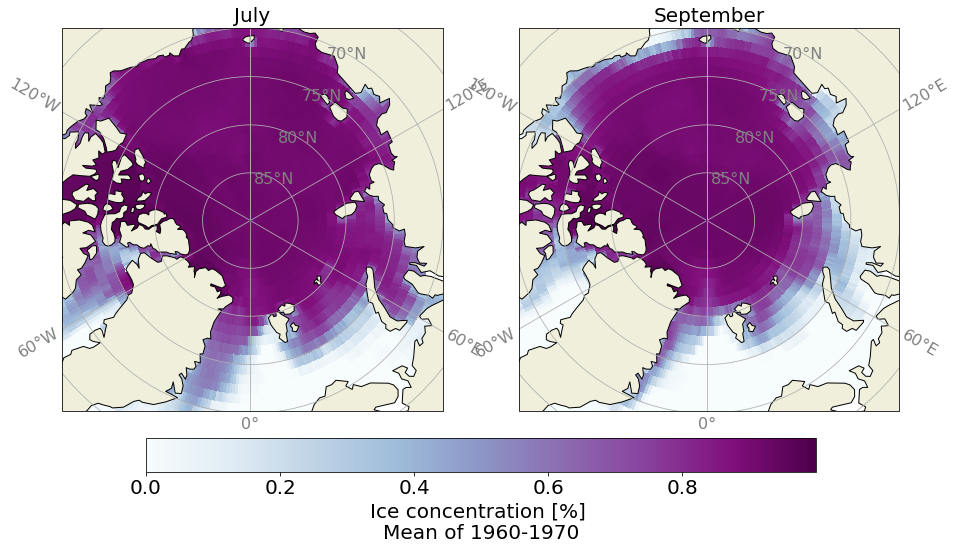

In [17]:
from F2R_sensitivity_toolbox import mygrid

units = 'Ice concentration [%] \nMean of {0}-{1}'.format(years_last10[0],years_last10[-1])
cmap = 'BuPu'

# North Polar Stereo Projection
fig = plt.figure(figsize=(15,10))
plot_extent = [-180, 180, 70, 90]

# -------------------------------------------------------------------------------
# July
ax1 = plt.subplot(1,2,1,projection = ccrs.NorthPolarStereo())
m1 = ax1.pcolormesh(londic, latdic, aIce_monthly_interp_JUL, 
    transform = ccrs.PlateCarree(),
    cmap=cmap)

mygrid(ax1,grid=True)

ax1.set_extent(plot_extent, crs=ccrs.PlateCarree())
ax1.set_title('July',fontsize=20)

# -------------------------------------------------------------------------------
# September
ax2 = plt.subplot(1,2,2,projection = ccrs.NorthPolarStereo())
m2 = ax2.pcolormesh(londic, latdic, aIce_monthly_interp_SEP, 
    transform = ccrs.PlateCarree(),
    cmap=cmap)

mygrid(ax2,grid=True)

ax2.set_extent(plot_extent, crs=ccrs.PlateCarree())
ax2.set_title('September',fontsize=20)

# -------------------------------------------------------------------------------
# colorbar
cbar = fig.colorbar(m1, ax=[ax1,ax2],orientation = 'horizontal',
                    fraction=0.1, pad=0.05, shrink = 0.8) 
cbar.set_label(units, fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

